In [1]:
%pip install pandas numpy matplotlib seaborn scikit-learn
%pip install -U scikit-learn


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Installing Required Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


1. Load Data + Handle Missing Values

In [3]:
# Import the pandas library
import pandas as pd

# Load the CSV file (reads the 'Student_Mental_health.csv' file located in the same directory into a DataFrame)
df = pd.read_csv("Student_Mental_health.csv")

# Rename the column names
df.columns = [
    'Timestamp',     # Survey submission time (not used in analysis)
    'Gender',        # Gender information (e.g., Female, Male)
    'Age',           # Age
    'Course',        # Course of study (major)
    'Year',          # Current academic year (e.g., Year 1, Year 2)
    'CGPA',          # Cumulative GPA (range format, e.g., 3.00 - 3.49)
    'Married',       # Marital status (Yes/No)
    'Depression',    # Presence of depression (Yes/No)
    'Anxiety',       # Presence of anxiety (Yes/No)
    'Panic',         # Presence of panic attacks (Yes/No)
    'Treatment'      # Whether received mental health treatment or counseling (Yes/No)
]


2. Create a numerical Stress_level target (Since it's not in the CSV, we logically generate it based on actual stress-related factors)

In [4]:
# Import numpy library (used for numerical computations)
import numpy as np

# Create the target variable 'Stress_level'
# ※ Assumption: Higher CGPA and presence of depression, anxiety, or panic attacks indicate a higher stress level

# 1. Convert binary categorical columns (Yes/No) to numeric format (necessary for model training)
df['Depression_bin'] = df['Depression'].map({'Yes': 1, 'No': 0})  # Depression → 1 or 0
df['Anxiety_bin']    = df['Anxiety'].map({'Yes': 1, 'No': 0})     # Anxiety → 1 or 0
df['Panic_bin']      = df['Panic'].map({'Yes': 1, 'No': 0})       # Panic → 1 or 0

# 2. Extract average value from CGPA column (e.g., "3.00 - 3.49" → 3.00)
# Use regular expression to extract the first float value and convert to float type
df['CGPA_val'] = df['CGPA'].str.extract(r'(\d+\.\d+)').astype(float)

# 3. Calculate Stress_level (based on a hypothetical formula)
# Depression and anxiety are assumed to have the most impact, weighted at 1.5
# Panic attacks are weighted at 1.0
# CGPA is assumed to increase stress linearly from a baseline of 2.0
df['Stress_level'] = (
    df['Depression_bin'] * 1.5 +       # Depression contributes 1.5 points
    df['Anxiety_bin'] * 1.5 +          # Anxiety contributes 1.5 points
    df['Panic_bin'] * 1.0 +            # Panic contributes 1.0 point
    (df['CGPA_val'] - 2.0) * 1.0       # CGPA adjustment starting from 2.0
).round(2)                             # Round stress level to 2 decimal places


3. Feature Selection and Missing Value Handling

In [5]:
# Create a new DataFrame with only the selected columns
df_model = df[[  
    'Stress_level',   # Target variable (continuous): the variable to be predicted
    'CGPA_val',       # Numerical feature: GPA (normalized value)
    'Depression',     # Categorical feature: Depression status (Yes/No)
    'Anxiety',        # Categorical feature: Anxiety status (Yes/No)
    'Panic',          # Categorical feature: Panic attack status (Yes/No)
    'Gender'          # Categorical feature: Gender (Female/Male)
]].copy()  # Use .copy() to avoid modifying the original data

# Remove missing values (essential preprocessing before model training)
df_model.dropna(inplace=True)


4. Categorical Encoding (Using get\_dummies)

In [6]:
# get_dummies encoding (binary dummy encoding with drop_first=True)
df_encoded = pd.get_dummies(
    df_model,                             # original DataFrame
    columns=['Depression', 'Anxiety', 'Panic', 'Gender'],  # specify categorical columns to encode
    drop_first=True                      # drop the first category to avoid multicollinearity
)


5. Numerical Feature Scaling (StandardScaler)

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()  # Initialize the standard scaler
df_encoded[['CGPA_val']] = scaler.fit_transform(df_encoded[['CGPA_val']])  # Apply standard scaling to 'CGPA_val'


6. Correlation Visualization

C:\Users\Diana\AppData\Local\Temp\ipykernel_30492\734595013.py:13: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()  # Adjust spacing
C:\Users\Diana\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


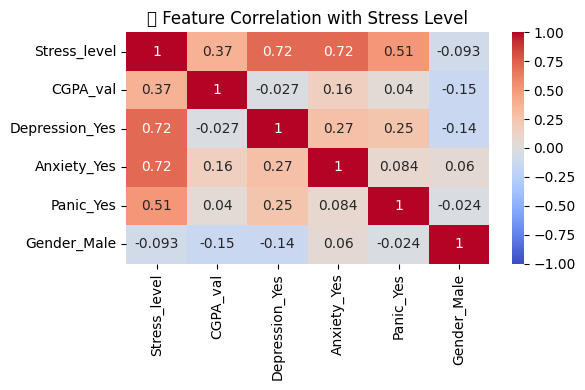

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualize the full correlation heatmap
plt.figure(figsize=(6, 4))  # Adjust the figure size
sns.heatmap(
    df_encoded.corr(),      # Correlation analysis on encoded and scaled DataFrame
    annot=True,             # Show correlation coefficients
    cmap='coolwarm',        # Color scheme: blue to red
    vmin=-1, vmax=1         # Fix value range for consistency
)
plt.title("📊 Feature Correlation with Stress Level")  # Set plot title
plt.tight_layout()  # Adjust spacing
plt.show()


7. Splitting X and y, and Dividing into Training and Test Sets

In [9]:
# Separate target and features
# - X: Independent variables (factors that might affect stress)
# - y: Dependent variable (the target to predict: Stress_level)
X = df_encoded.drop(columns=['Stress_level'])  # Store all features except the target in X
y = df_encoded['Stress_level']                 # Set Stress_level as the target for prediction

# Split into training and test sets
# - Split the entire dataset into 80% training and 20% test data
# - Set random_state to ensure reproducibility
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)


8. Implementing and Evaluating the LinearRegression Model

In [10]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# Constructing the pipeline
# - Using scikit-learn's Pipeline to structure the model
# - This makes it easier to maintain structure when tuning or performing cross-validation
pipe_lr = Pipeline([
    ('model', LinearRegression())  # The model is labeled 'model'
])

# Cross-validation
# - Measures the model’s generalization performance on the training data
# - R² score is used as the performance metric, with 5-fold splitting
scores_lr = cross_val_score(pipe_lr, X_train, y_train, cv=5, scoring='r2')
print("🔷 LinearRegression Cross-Validation R² Mean:", round(scores_lr.mean(), 4))

# Model training and prediction
pipe_lr.fit(X_train, y_train)             # Train the model on the full training set
y_pred_lr = pipe_lr.predict(X_test)      # Predict using the test data

# Print performance metrics
# - RMSE: Root Mean Squared Error
# - MAE: Mean Absolute Error
# - R² Score: Coefficient of determination (explained variance)
print("\nLinearRegression Evaluation")
print("RMSE :", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
print("MAE  :", mean_absolute_error(y_test, y_pred_lr))
print("R²   :", r2_score(y_test, y_pred_lr))


🔷 LinearRegression Cross-Validation R² Mean: 1.0

LinearRegression Evaluation
RMSE : 1.0921017084242304e-15
MAE  : 9.520327647920335e-16
R²   : 1.0


9. Implementation and Evaluation of the RandomForestRegressor Model

In [11]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Pipeline construction
# - RandomForestRegressor is wrapped in a pipeline to allow for easy tuning later
pipe_rf = Pipeline([
    ('model', RandomForestRegressor(random_state=42))
])

# Cross-Validation R² Score
# - Evaluate training performance using 5-fold cross-validation and calculate average R² score
scores_rf = cross_val_score(pipe_rf, X_train, y_train, cv=5, scoring='r2')
print("RandomForestRegressor Cross-Validation R² Mean:", round(scores_rf.mean(), 4))

# Model training and prediction
pipe_rf.fit(X_train, y_train)           # Train the model on the full training set
y_pred_rf = pipe_rf.predict(X_test)    # Predict on the test set

# Evaluation metrics
print("\nRandomForestRegressor Evaluation")
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))       # Root Mean Squared Error
print("MAE :", mean_absolute_error(y_test, y_pred_rf))               # Mean Absolute Error
print("R²  :", r2_score(y_test, y_pred_rf))                          # R² Score


RandomForestRegressor Cross-Validation R² Mean: 0.979

RandomForestRegressor Evaluation
RMSE: 0.10354122712371976
MAE : 0.05526666666666666
R²  : 0.9924530673847736


#test code#

In [12]:
'target_gpa' in X.columns
# Data leakage check — if it prints False, there is no data leakage


False

In [13]:
# 1. Check distribution of the target variable
print("Target distribution:")
print(y.value_counts(normalize=True))

# 2. Check similarity between X_train and X_test
print("\nSample of X_train:")
print(X_train.head())

print("\nSample of X_test:")
print(X_test.head())


Target distribution:
Stress_level
 2.50    0.217822
 1.50    0.168317
 1.00    0.158416
 3.00    0.108911
 4.00    0.108911
 5.50    0.049505
 4.50    0.039604
 5.00    0.039604
-0.01    0.029703
 2.00    0.029703
 3.50    0.019802
 0.50    0.009901
 0.00    0.009901
 0.99    0.009901
Name: proportion, dtype: float64

Sample of X_train:
    CGPA_val  Depression_Yes  Anxiety_Yes  Panic_Yes  Gender_Male
89 -2.860009           False        False       True         True
26  0.844603           False        False      False        False
42 -0.390268            True        False      False        False
70 -0.390268           False        False      False        False
15  0.844603           False        False      False         True

Sample of X_test:
    CGPA_val  Depression_Yes  Anxiety_Yes  Panic_Yes  Gender_Male
84 -0.390268           False        False      False         True
55 -0.390268           False        False      False         True
66 -0.390268           False         True      F

10. LinearRegression Evaluation + Scatter Plot

LinearRegression Performance Evaluation
RMSE : 0.0
MAE  : 0.0
R²   : 1.0


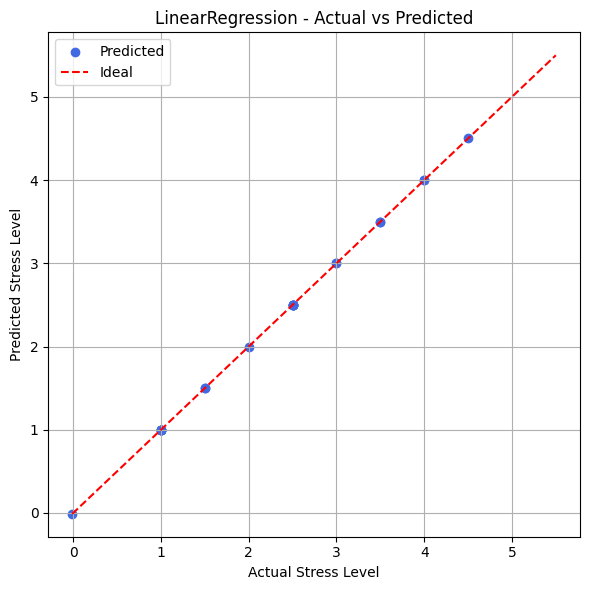

In [14]:
# Performance output
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))      # RMSE (Root Mean Squared Error)
mae_lr = mean_absolute_error(y_test, y_pred_lr)               # MAE (Mean Absolute Error)
r2_lr = r2_score(y_test, y_pred_lr)                           # R² (Coefficient of Determination)

# Display results
print("LinearRegression Performance Evaluation")
print("RMSE :", round(rmse_lr, 4))
print("MAE  :", round(mae_lr, 4))
print("R²   :", round(r2_lr, 4))

# Visualization of predictions
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_lr, color='royalblue', label='Predicted')  # Prediction points
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal') # Perfect prediction reference line
plt.title("LinearRegression - Actual vs Predicted")
plt.xlabel("Actual Stress Level")
plt.ylabel("Predicted Stress Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


11. RandomForestRegressor Evaluation and Scatter Plot

RandomForestRegressor Performance Evaluation
RMSE : 0.1035
MAE  : 0.0553
R²   : 0.9925


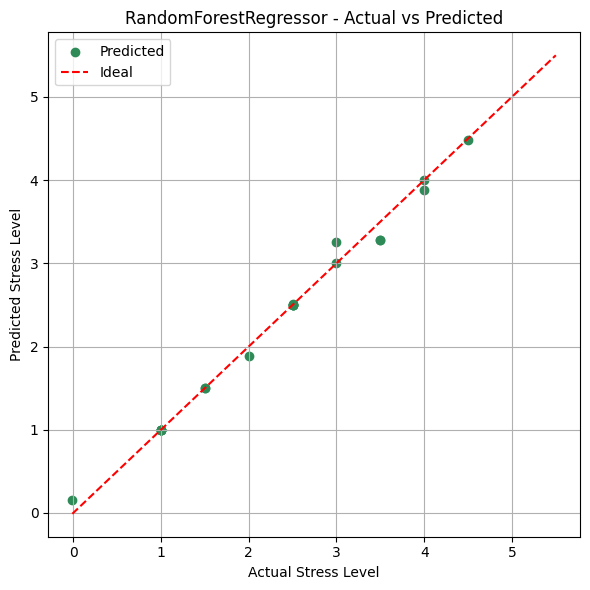

In [16]:
# Performance metric calculation
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))  # RMSE (Root Mean Squared Error)
mae_rf = mean_absolute_error(y_test, y_pred_rf)           # MAE (Mean Absolute Error)
r2_rf = r2_score(y_test, y_pred_rf)                       # R² (Coefficient of Determination)

# Print results
print("RandomForestRegressor Performance Evaluation")
print("RMSE :", round(rmse_rf, 4))
print("MAE  :", round(mae_rf, 4))
print("R²   :", round(r2_rf, 4))

# Visualization of prediction results
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_rf, color='seagreen', label='Predicted')  # Predicted values
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal')  # Ideal prediction line
plt.title("RandomForestRegressor - Actual vs Predicted")
plt.xlabel("Actual Stress Level")
plt.ylabel("Predicted Stress Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Residual Analysis Visualization

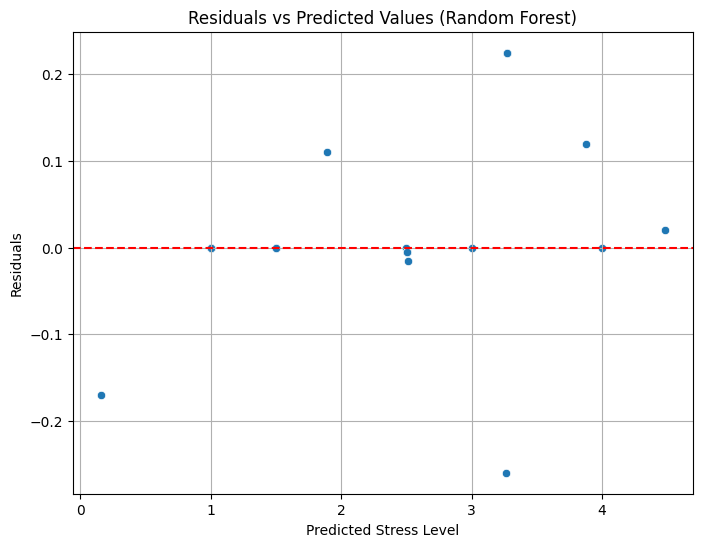

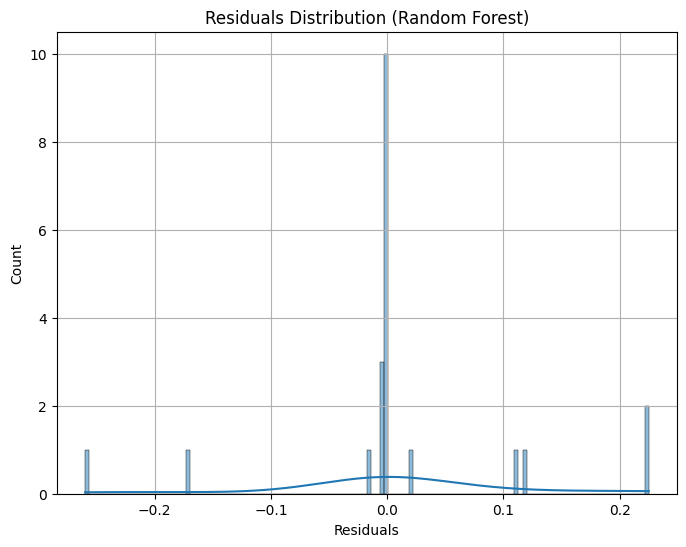

In [17]:
# Calculate residuals
residuals = y_test - y_pred_rf

# 1. Residuals vs Predicted Values
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.xlabel('Predicted Stress Level')
plt.ylabel('Residuals')
plt.title('Residuals vs Predicted Values (Random Forest)')
plt.grid(True)
plt.show()

# 2. Residuals Histogram
plt.figure(figsize=(8, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residuals')
plt.title('Residuals Distribution (Random Forest)')
plt.grid(True)
plt.show()


12. Hyperparameter Tuning + Visualization Included

✅ Best Hyperparameters: {'model__max_depth': None, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2, 'model__n_estimators': 50}

📈 Performance of Best Model on Test Set
RMSE : 0.1006
MAE  : 0.0526
R²   : 0.9929


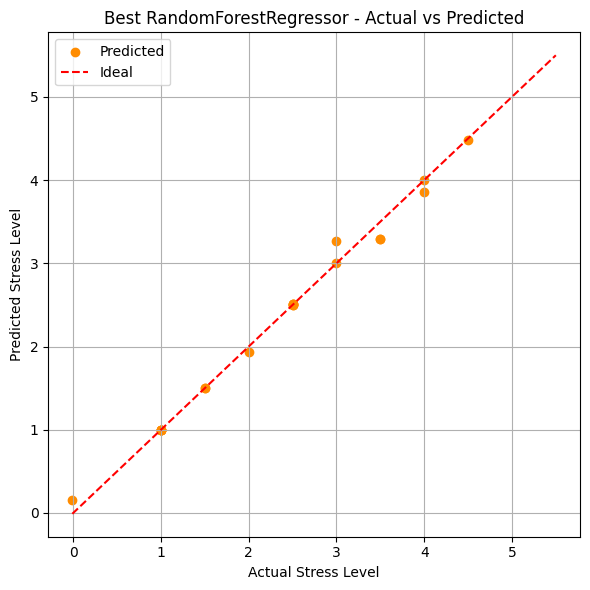

In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

# 1. Define hyperparameter search space
# Specify the combinations of RandomForestRegressor parameters to explore
param_grid = {
    'model__n_estimators': [50, 100],             # Number of trees: 50 or 100
    'model__max_depth': [None, 5, 10],            # Maximum depth: unlimited / 5 / 10
    'model__min_samples_split': [2, 5],           # Minimum samples to split a node
    'model__min_samples_leaf': [1, 2]             # Minimum samples required at a leaf node
}

# 2. Build the pipeline
# Wrap the model in a pipeline so it can be used with GridSearchCV
pipe = Pipeline([
    ('model', RandomForestRegressor(random_state=42))
])

# 3. Initialize GridSearchCV
# Use 5-fold cross-validation, R² as the scoring metric, and utilize all CPU cores
grid_search = GridSearchCV(pipe, param_grid, cv=5, scoring='r2', n_jobs=-1)

# 4. Fit the grid search on training data
# Evaluate performance across all parameter combinations
grid_search.fit(X_train, y_train)

# 5. Extract the best model and generate predictions
# Retrieve the best-performing model from grid search
best_model = grid_search.best_estimator_
y_pred_best = best_model.predict(X_test)

# 6. Compute performance metrics
# Use RMSE, MAE, and R² to evaluate regression accuracy
rmse_best = np.sqrt(mean_squared_error(y_test, y_pred_best))
mae_best = mean_absolute_error(y_test, y_pred_best)
r2_best = r2_score(y_test, y_pred_best)

# 7. Display best parameters and performance
print("✅ Best Hyperparameters:", grid_search.best_params_)
print("\n📈 Performance of Best Model on Test Set")
print("RMSE :", round(rmse_best, 4))  # Root Mean Squared Error
print("MAE  :", round(mae_best, 4))   # Mean Absolute Error
print("R²   :", round(r2_best, 4))    # R² Score (higher is better)

# 8. Visualize predictions vs. actual values
# Compare actual stress levels (y_test) with predicted values (y_pred_best)
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred_best, color='darkorange', label='Predicted')  # Prediction points
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='Ideal')   # Perfect prediction line
plt.title("Best RandomForestRegressor - Actual vs Predicted")
plt.xlabel("Actual Stress Level")
plt.ylabel("Predicted Stress Level")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
